In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.options.mode.chained_assignment = None  # default='warn'

In [27]:
df = pd.read_csv('nyc_energy_consumption.csv')
df
# parse_dates=True, if added to read_csv then this argument set to True means that pandas 
# will attempt to parse the dates in the CSV file and convert them into datetime objects. 
# This is useful for time series data where the 'date' column contains date information.

# !!! possible code for data aggeragate to generate monthly value and rename below:
# df = pd.read_csv('df.csv',parse_dates=True,index_col='date')
# df = pd.DataFrame(df.groupby(df.index.strftime('%Y-%m')).sum()['amount'])
# df.columns=['Value']

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.5,0.0000,46.13
1,2012-01-01 01:00:00,4752.1,0.0000,45.89
2,2012-01-01 02:00:00,4542.6,0.0000,45.04
3,2012-01-01 03:00:00,4357.7,0.0000,45.03
4,2012-01-01 04:00:00,4275.5,0.0000,42.61
...,...,...,...,...
49200,2017-08-12 02:00:00,NaN,0.0000,70.84
49201,2017-08-12 03:00:00,NaN,0.0000,70.57
49202,2017-08-12 04:00:00,NaN,0.0000,69.89
49203,2017-08-12 05:00:00,NaN,0.0000,68.59


In [35]:
# some preprocessing necessary to the raw data
# df = pd.DataFrame(columns=['timeStamp','demand'])
# df.shape
columns=['timeStamp','demand']
# df1 = df[columns].dropna() ,but not to drop hereby
df1 = df[columns].copy()

df1.shape

(49205, 2)

In [54]:
# We break down the ARIMA Model into 3 steps: AR -auto regression , I -Integrated (differencing), 
# MA - Moving Average on the residuals

# p - how many past sequences
def AR(p,df):
    df_temp = df
    for i in range(1,p+1):
        df_temp['Shifted_val_%d'%i] = df_temp['demand'].shift(i)
    train_size = (int)(0.8 * df_temp.shape[0])
    
    #Breaking data set into test and training
    df_train = pd.DataFrame(df_temp[0:train_size])
    df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

    df_train_2 = df_train.dropna()
    #X contains the lagged values ,hence we skip the first column
    X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)
    #Y contains the value,it is the first column
    y_train = df_train_2.iloc[:,0].values.reshape(-1,1)

    #Running linear regression to generate the coefficents of lagged terms
    from sklearn.linear_model import LinearRegression
    lr = LinearRegression()
    lr.fit(X_train,y_train)

    theta  = lr.coef_.T
    intercept = lr.intercept_
    df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
    # df_train_2[['Value','Predicted_Values']].plot()

    X_test = df_test.iloc[:,1:].values.reshape(-1,p)
    df_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
    # df_test[['Value','Predicted_Values']].plot()

    RMSE = np.sqrt(mean_squared_error(df_test['demand'], df_test['Predicted_Values']))

    print("The RMSE is :", RMSE,", Value of p : ",p)
    return [df_train_2,df_test,theta,intercept,RMSE]

In [45]:
def MA(q,res):

    for i in range(1,q+1):
        res['Shifted_values_%d' % i ] = res['Residuals'].shift(i)

    train_size = (int)(0.8 * res.shape[0])

    res_train = pd.DataFrame(res[0:train_size])
    res_test = pd.DataFrame(res[train_size:res.shape[0]])

    res_train_2 = res_train.dropna()
    X_train = res_train_2.iloc[:,1:].values.reshape(-1,q)
    y_train = res_train_2.iloc[:,0].values.reshape(-1,1)

    from sklearn.linear_model import LinearRegression
    lr = LinearRegression()
    lr.fit(X_train,y_train)

    theta  = lr.coef_.T
    intercept = lr.intercept_
    res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
    # res_train_2[['Residuals','Predicted_Values']].plot()

    X_test = res_test.iloc[:,1:].values.reshape(-1,q)
    res_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
    res_test[['Residuals','Predicted_Values']].plot()

    from sklearn.metrics import mean_squared_error
    RMSE = np.sqrt(mean_squared_error(res_test['Residuals'], res_test['Predicted_Values']))

    print("The RMSE is :", RMSE,", Value of q : ",q)
    return [res_train_2,res_test,theta,intercept,RMSE]


In [6]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','Number of Lags Used',\
              'Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, \
              reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series \
              has a unit root, indicating it is non-stationary \n")

In [36]:
# Step 1 : Making the data stationary
# Different techniques can be used to make the data stationary, 
# used log and differencing. The additional diff(12) is remove the seasonality.

df_testing = pd.DataFrame(np.log(df1.demand).diff().diff(12))
adf_check(df_testing.demand.dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -48.416241036627966
p-value : 0.0
Number of Lags Used : 57
Number of Observations Used : 49053
strong evidence against the null hypothesis,               reject the null hypothesis. Data has no unit root and is stationary


<AxesSubplot:>

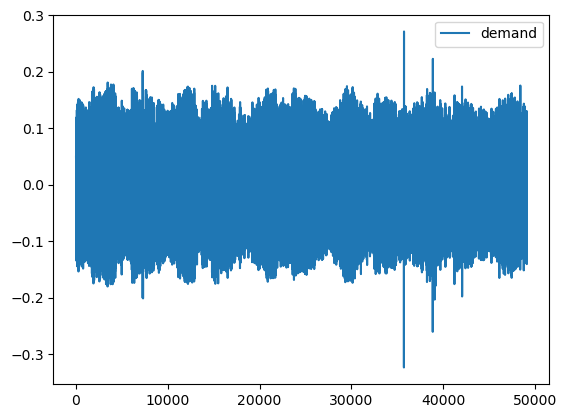

In [40]:
# print(df_testing.to_string())
df_testing.plot()

/Users/mc/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


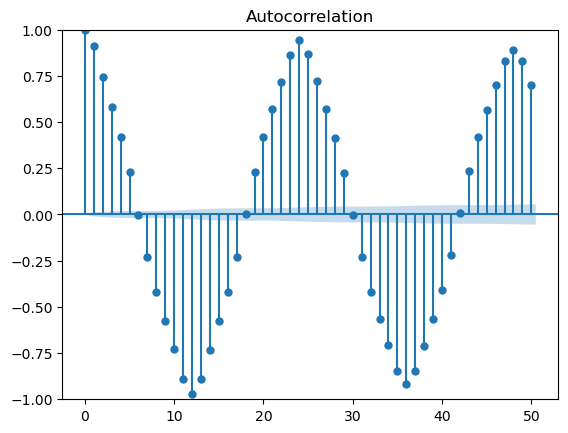

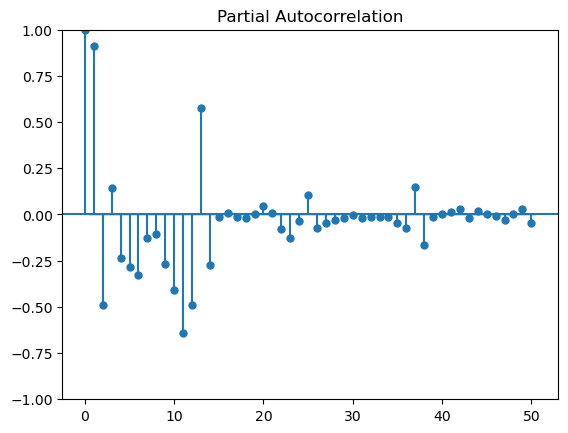

In [34]:

ACF = plot_acf(df_testing.dropna(),lags=50)
PACF = plot_pacf(df_testing.dropna(),lags=50)

In [55]:
# Step 2 : Fitting AR Model
# We calculate the error on the test-set for each p, and pick the best one.

best_RMSE=100000000000
best_p = -1

for i in range(1,21):
  [df_train,df_test,theta,intercept,RMSE] = AR( i,pd.DataFrame(df_testing.demand) )
  if(RMSE<best_RMSE):
    best_RMSE = RMSE
    best_p = i
  
print(best_p)

# !!!!!!!!!!!!
# !!!!!!!!!!!
# !!!!!!!!!!
#printing error due to the dataset has NaN, still wanting a best practice sol

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [49]:
[df_train,df_test,theta,intercept,RMSE] = AR(best_p,pd.DataFrame(df_testing.Value))

AttributeError: 'DataFrame' object has no attribute 'Value'

In [ ]:
df_c = pd.concat([df_train,df_test])
df_c[['Value','Predicted_Values']].plot()
res = pd.DataFrame()

res['Residuals'] = df_c.Value - df_c.Predicted_Values

res.plot(kind='kde')

In [51]:
# Step 3 : Fitting MA on Residuals

# best_RMSE=100000000000
# best_q = -1

# for i in range(1,13):
#     [res_train,res_test,theta,intercept,RMSE] = MA(i,pd.DataFrame(res.Residuals))
#     if(RMSE<best_RMSE):
#         best_RMSE = RMSE
#         best_q = i
  
# print(best_q)

In [ ]:
df_c[['demand','Predicted_Values']].plot()

In [ ]:
# Step 4 : Getting Back Original data
# Reversing the steps performed for differencing, as
# a check the first column (Value) must be the same after reversing the steps.
df_c.Value += np.log(df).shift(1).Value
df_c.Value += np.log(df).diff().shift(12).Value
df_c.Predicted_Values += np.log(df).shift(1).Value 
df_c.Predicted_Values += np.log(df).diff().shift(12).Value
df_c.Value = np.exp(df_c.Value)
df_c.Predicted_Values = np.exp(df_c.Predicted_Values)


df_c

<class 'numpy.ndarray'>
